In [ ]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
from scipy.signal import convolve2d
import plot_utils

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

In [ ]:
dat = np.load('Data/Cat-SFG-17-01-2020.npz')
dat.files

In [3]:
dat['listgal'].shape

(300, 96, 96)

In [4]:
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [5]:
gal = cv.resize(dat['listgal'][0,:,:], (64,64))
psf = cv.resize(galsim.Image(img1, copy=True).array, (64,64))

gal_up = cv.resize(dat['listgal'][0,:,:], (64*4,64*4))                   # Upsampled to remove alising
psf_up = cv.resize(galsim.Image(img1, copy=True).array, (64*4,64*4))

psf /= np.sum(psf)             # PSF flux = 1
psf_up /= np.sum(psf_up)

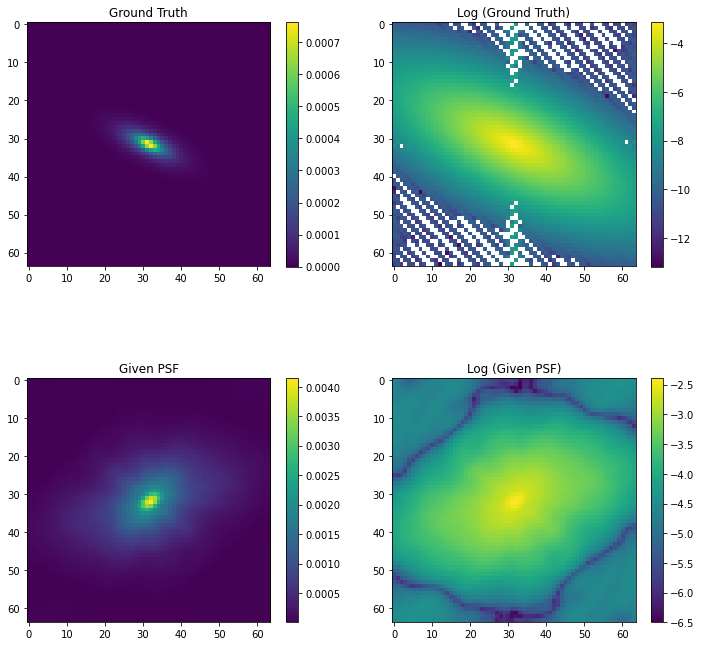

In [6]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
plt.imshow(gal)
plt.colorbar(shrink=0.825)
plt.title('Ground Truth')

plt.subplot(222)
plt.imshow(np.log10(gal))
plt.colorbar(shrink=0.825)
plt.title('Log (Ground Truth)')

plt.subplot(223)
plt.imshow(psf)
plt.colorbar(shrink=0.825)
plt.title('Given PSF')

plt.subplot(224)
plt.imshow(np.log10(psf))
plt.colorbar(shrink=0.825)
plt.title('Log (Given PSF)')

plt.show()

### FFT(Ground Truth) + Gaussian Noise

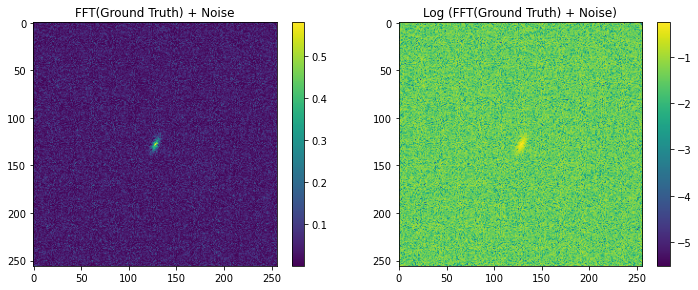

0.05687359927909602


In [7]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal_up))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf_up))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 50                                                          # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(np.abs(gal_fft_GSO.array))
plt.colorbar(shrink=0.375)
plt.title('FFT(Ground Truth) + Noise')

plt.subplot(122)
plt.imshow(np.log10(np.abs(gal_fft_GSO.array)))
plt.colorbar(shrink=0.375)
plt.title('Log (FFT(Ground Truth) + Noise)')

plt.show()

print(sigma_noise)

### Convolve with PSF

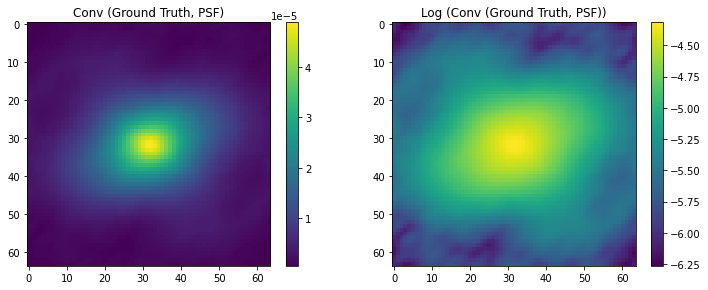

(0.03039730529252081, 0.030397305292520813)

In [8]:
conv = gal_fft_GSO.array * psf_fft

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))     # IFFT to get back to brightness domain
final_gal = cv.resize(final_gal, (64,64))    
final_gal *= (np.sum(gal)/np.sum(final_gal))                                   # Normalisation

fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(final_gal)
plt.colorbar(shrink=0.375)
plt.title('Conv (Ground Truth, PSF)')

plt.subplot(122)
plt.imshow(np.log10(final_gal))
plt.colorbar(shrink=0.375)
plt.title('Log (Conv (Ground Truth, PSF))')

plt.show()

np.sum(final_gal), np.sum(gal)

# ADMM

In [9]:
# Utility Functions

def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

def fft(data):

    return (1 / np.sqrt(data.size) *
            np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))

def ifft(data):

    return (np.sqrt(data.size) *
            np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))

def nmse(signal_1, singal_2):

    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)

def max_sv(psf, sigma, rho):

    H = np.fft.fft2(psf)
    normH = np.abs(np.rot90(H, 2)*H + rho*sigma**2)
    return np.real(np.max(normH))

In [10]:
# Projection - Enforce non-negative values
def proj(xi):

    return np.real(np.maximum(xi,0))


# H operator
def H(data, psf):

    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):

    return fftconvolve(data, np.rot90(psf, 2))


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, var):

    cost_val = (0.5 * rho * np.linalg.norm(z - x_rec)**2 - 
                np.dot(mu.flatten(),(z - x_rec).flatten()) + 
                (0.5/var) * np.linalg.norm(y - H(x_rec, psf))**2)

    return np.real(cost_val)


# gradient step size update
def get_alpha(rho, sv, sigma):

    return (1.0 / ((sv/(sigma**2) + rho)*(1.0 + 1.0e-5)))



# Run ADMM
def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, disp_step, n_iter):

    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = np.zeros(y.shape)
    count = 0

    # ADMM parameters
    x_k = x_0
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0                                  # Augmented lagrangian hyperparameter
    delta_k = 0.0      

    # FISTA parameters
    t_k = 1.0
    z_fista_old = z_0
    sigma = sigma_noise

    # square of spectral radius of convolution matrix
    sv = max_sv(psf, sigma, rho_k)         

    # The gradient descent step
    alpha = get_alpha(rho_k, sv, sigma)
    
    for k in range(n_iter):
     
        ## FISTA update

        x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf) + 
                                      mu_k * sigma**2 + 
                                      rho_k * sigma**2 * (z_fista_old - z_k))

        x_k1 = proj(x_k1)

        t_k1 = (1. + np.sqrt(4. * t_k**2 + 1.))/2.
        lambda_fista = 1 + (t_k - 1)/t_k1
        z_fista_new = x_k + lambda_fista * (x_k1 - x_k)

        z_fista_old = z_fista_new
        t_k = t_k1

        ## Denoising
        z_k1 = x_k1 + (mu_k/rho_k)

        ## mu update
        mu_k1 = mu_k + (x_k1 - z_k1) * rho_k

        ## Cost
        cost.append(cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2))

        ## Rho & alpha update

        if (gamma * rho_k < rho_max):

            delta_k1 = (1./y.shape[0])*(np.linalg.norm(x_k1 - x_k) + 
                                        np.linalg.norm(z_k1 - z_k) + 
                                        np.linalg.norm(mu_k1 - mu_k))

            if (delta_k1 > eta * delta_k):

                rho_k1 = gamma * rho_k
                alpha = get_alpha(rho_k1, sv, sigma)

            delta_k = delta_k1

        # Update all variables
        x_k = x_k1
        mu_k = mu_k1
        z_k = z_k1
        rho_k = rho_k1
        sv = max_sv(psf, sigma, rho_k)

        # Convert back to signal domain
        final_im = x_k

        # Compute NMSE
        nmse_arr[k] = nmse(gal, final_im)       
        
        # Check if optimal reconstruction is achieved
        if nmse_arr[k]==np.min(nmse_arr):
            x_opt = final_im

        if (k+1)%disp_step==0 and k!=0:
            plot_utils.plot_iter_np(final_im, gal, y, k)

    return x_opt, nmse_arr, cost

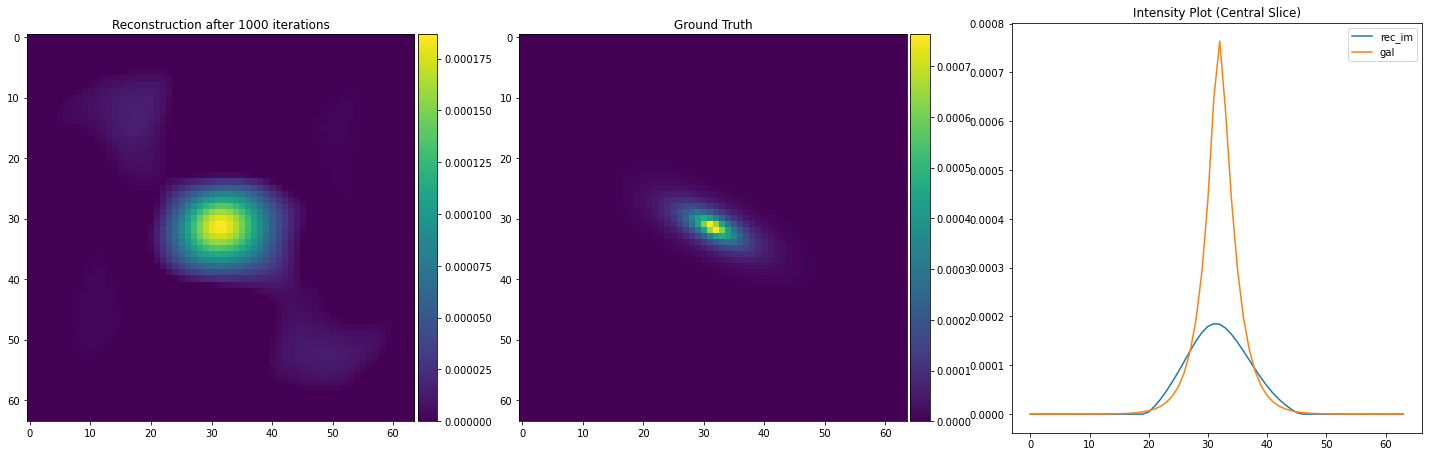

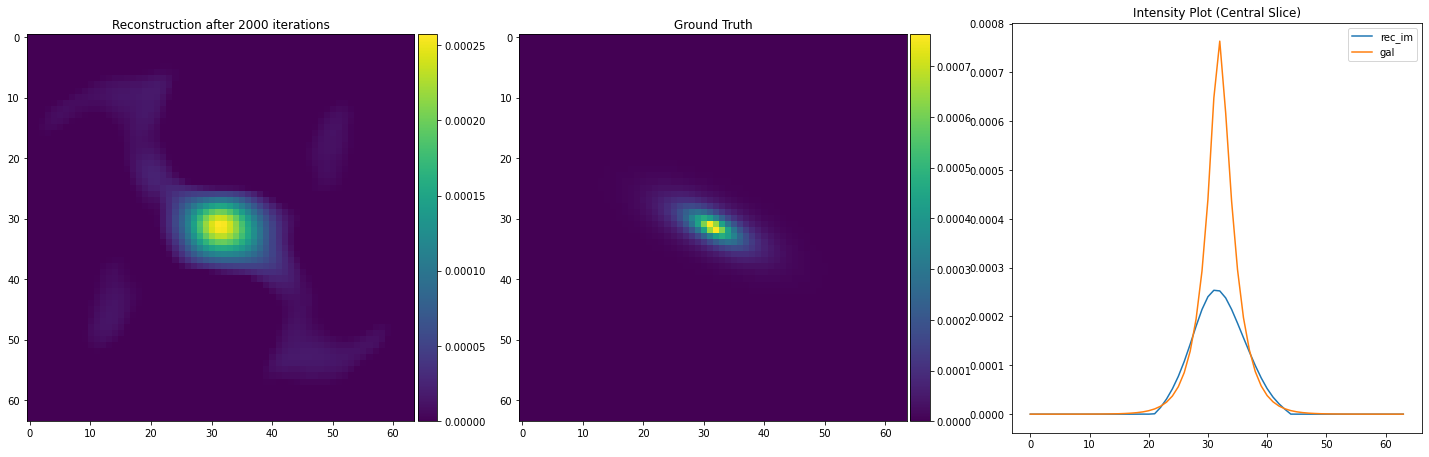

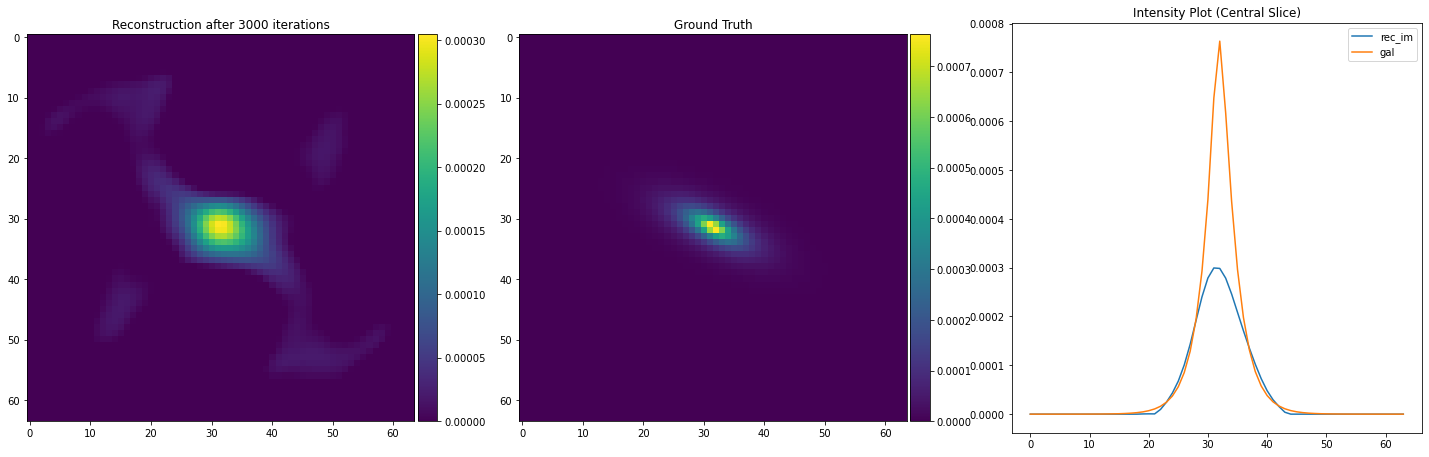

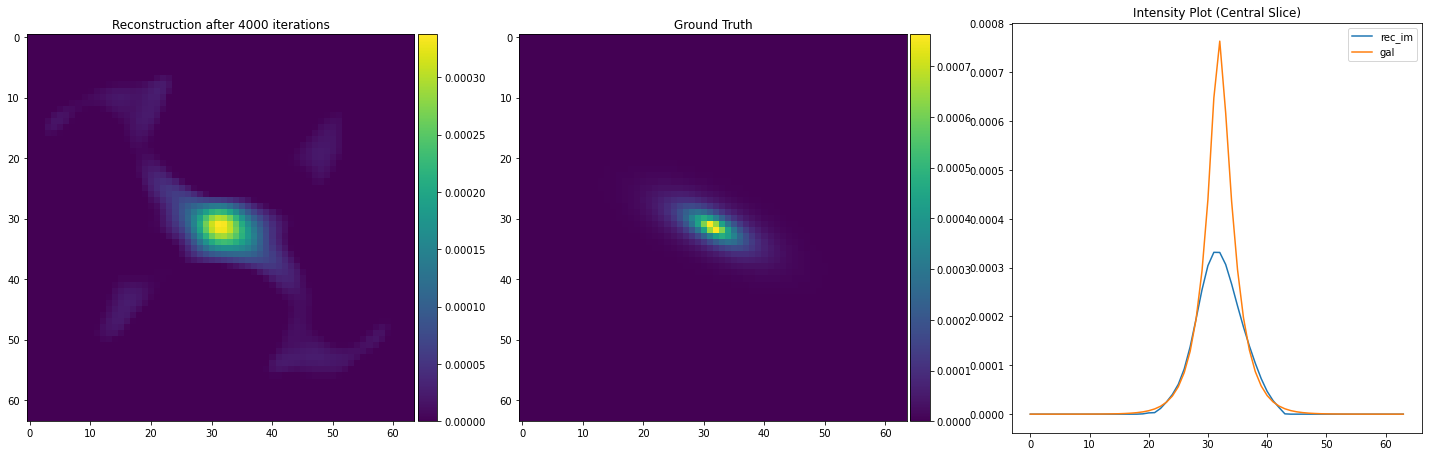

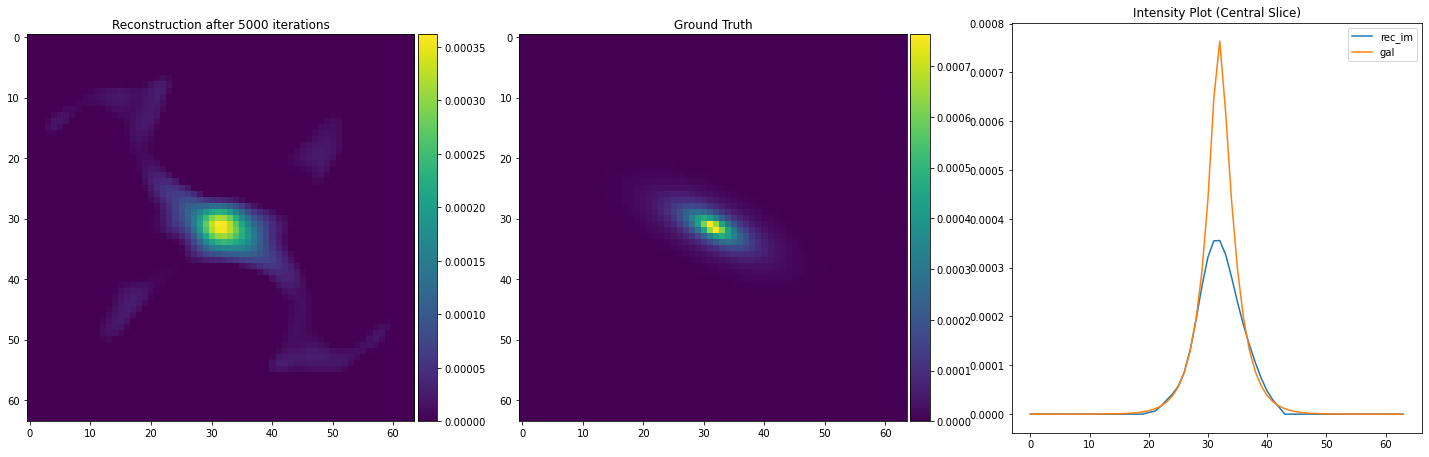

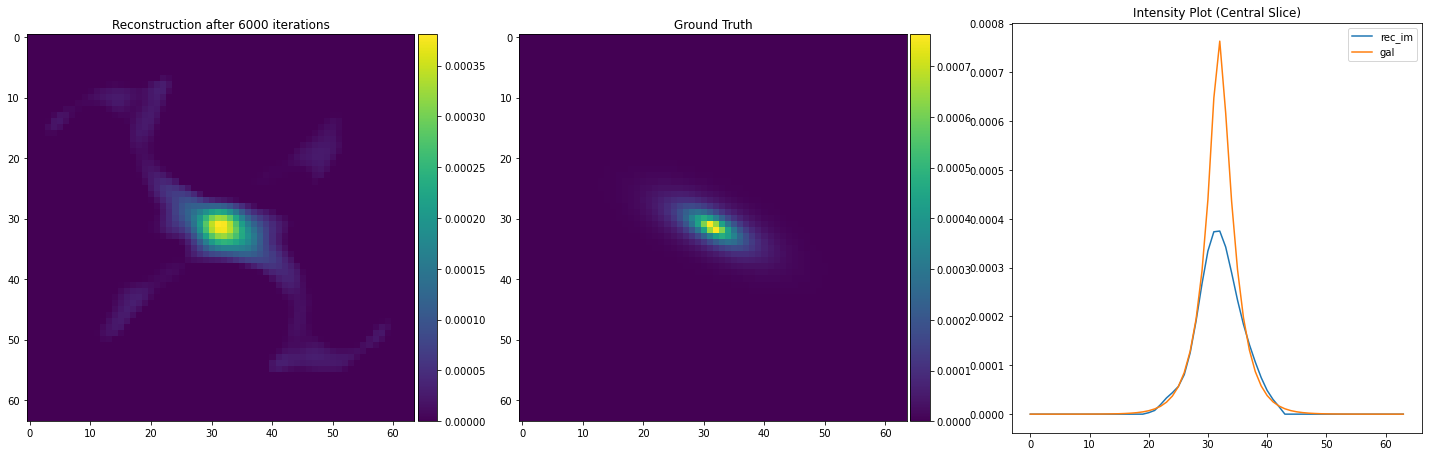

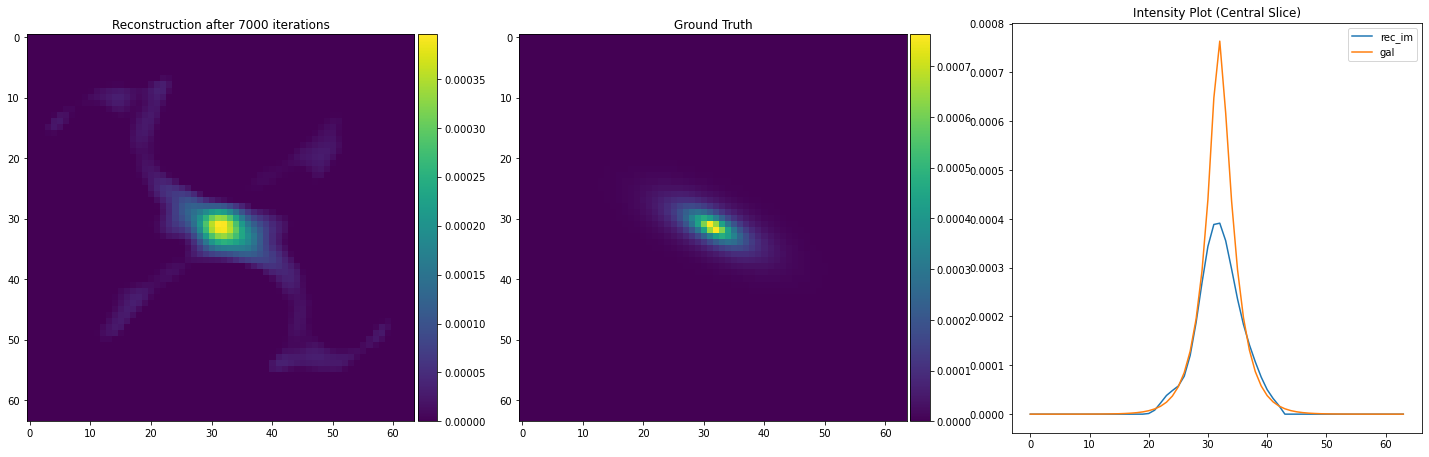

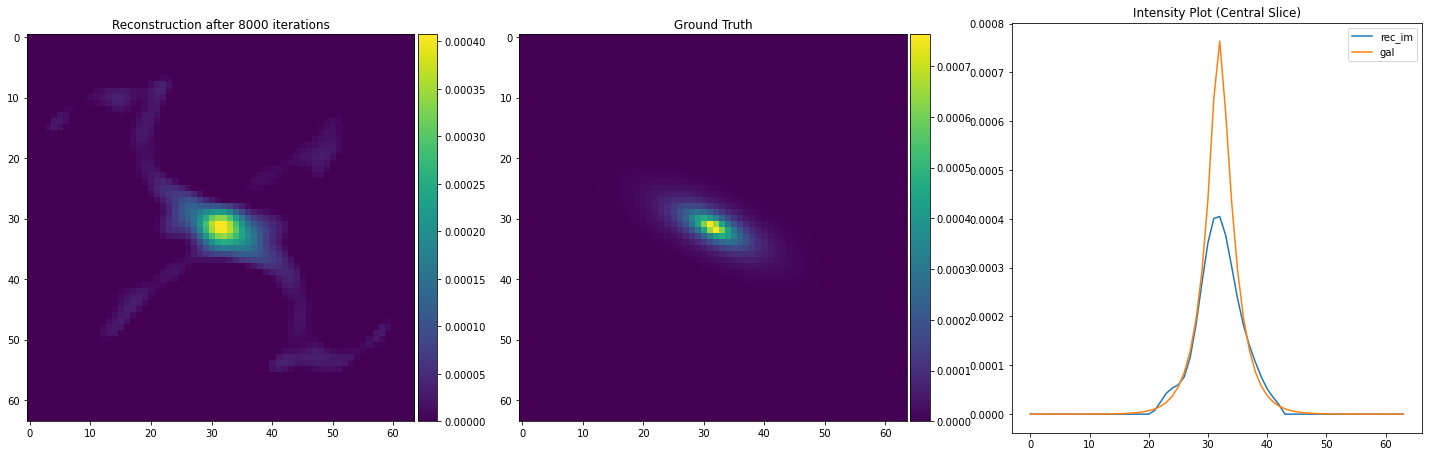

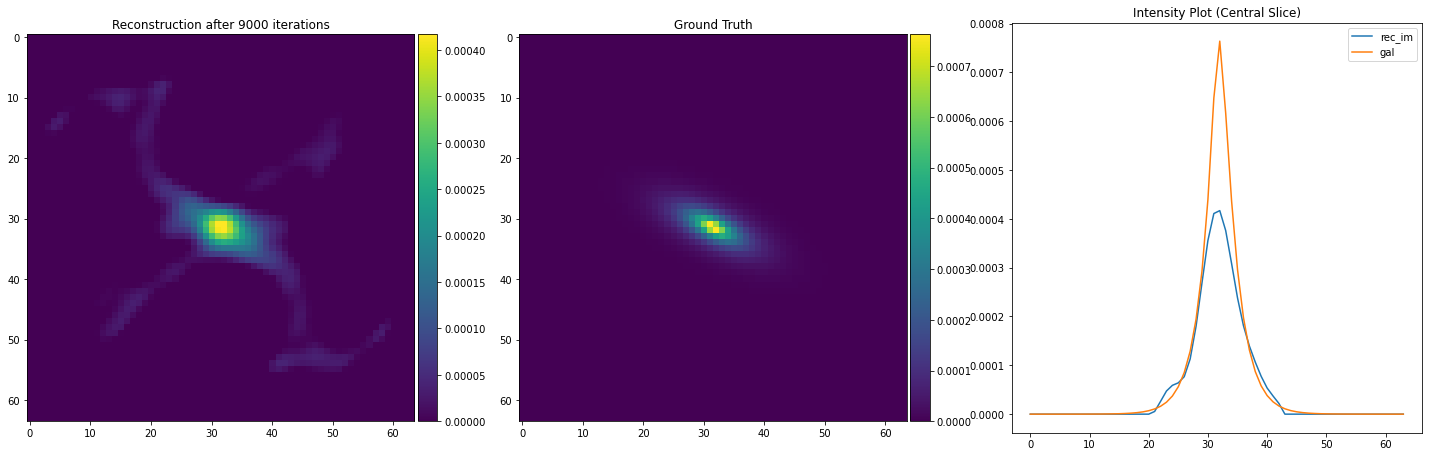

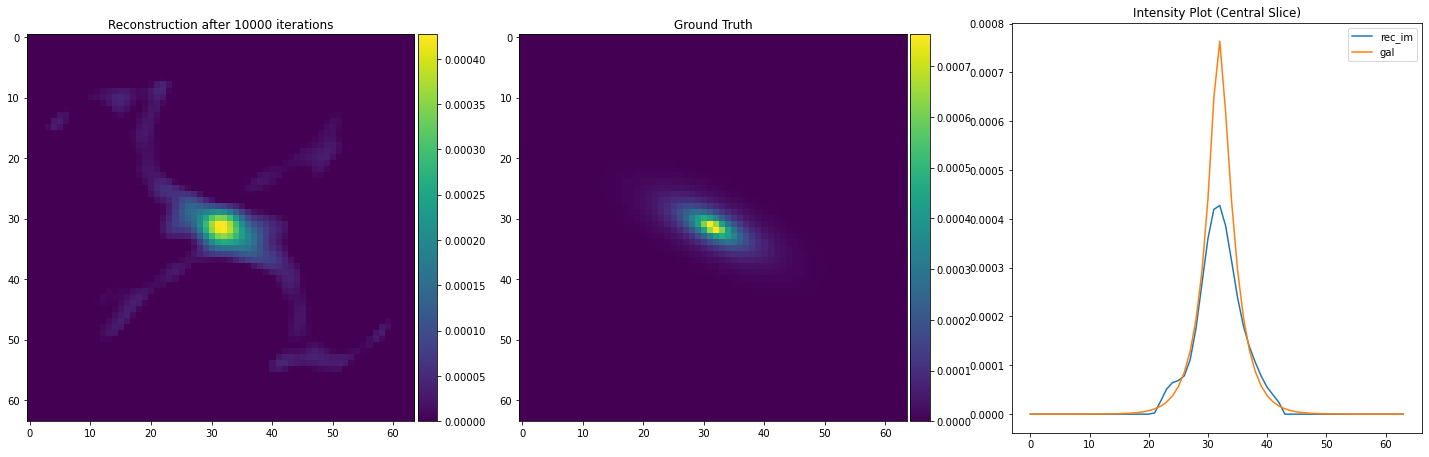

In [11]:
n_iter = 10000
disp_step = 1000

# ADMM parameters (initial)
x_0 = np.zeros(final_gal.shape)
z_0 = np.zeros(final_gal.shape)
mu_0 = 0.0
rho_0 = 50.0          # Augmented lagrangian hyperparameter
rho_max = 200.0       # max rho value
eta = 0.5             # should be between - [0, 1)
gamma = 1.4           # multiplicative rho factor -- Should be > 1


# Deconvolve the image
x_opt, nmse_arr, cost = runADMM(final_gal, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, 
                                eta, gamma, disp_step, n_iter=n_iter)

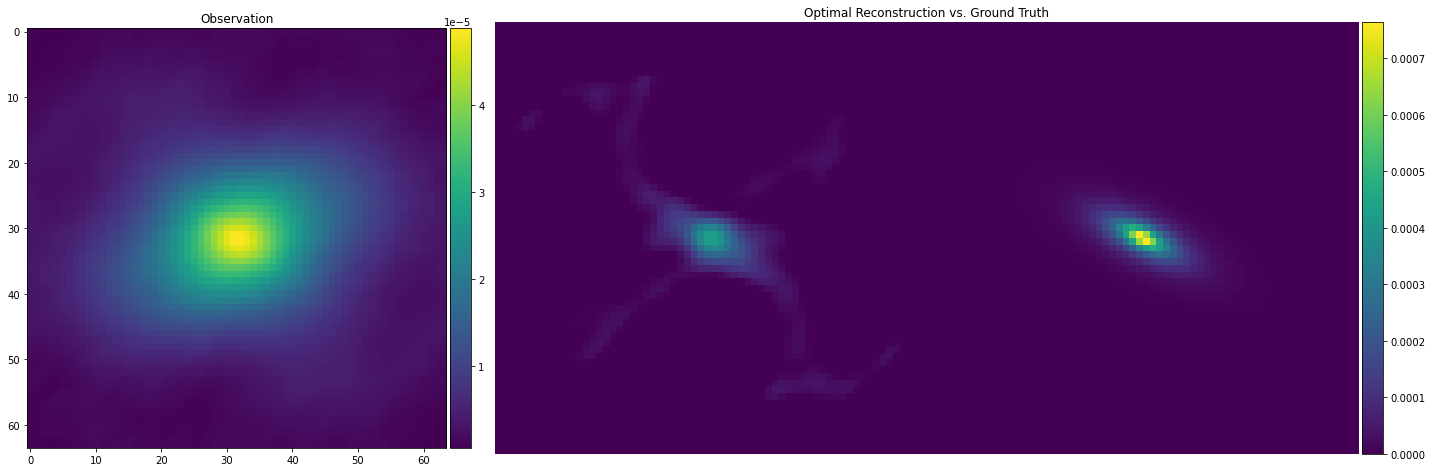

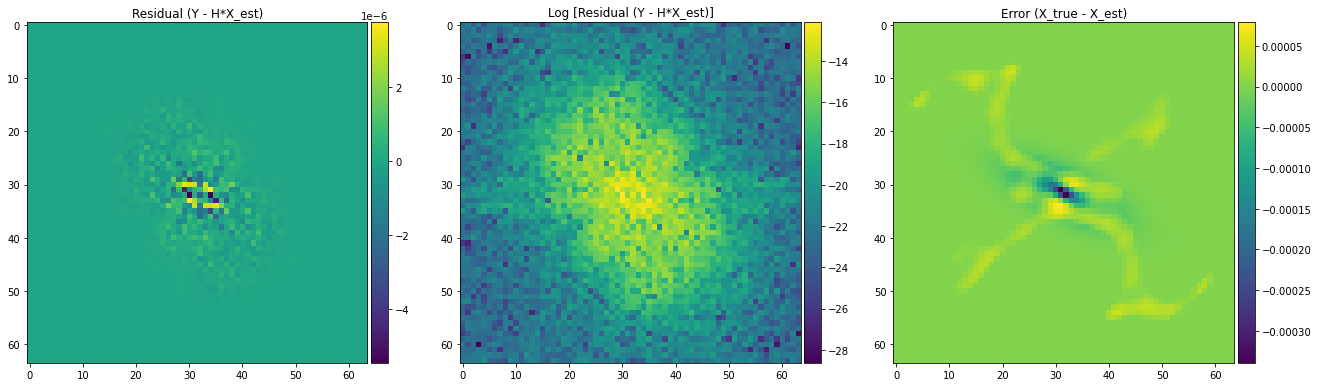

In [12]:
# Comparison
plot_utils.comparison_np(x_opt, gal, final_gal, psf, fftconvolve, fft)

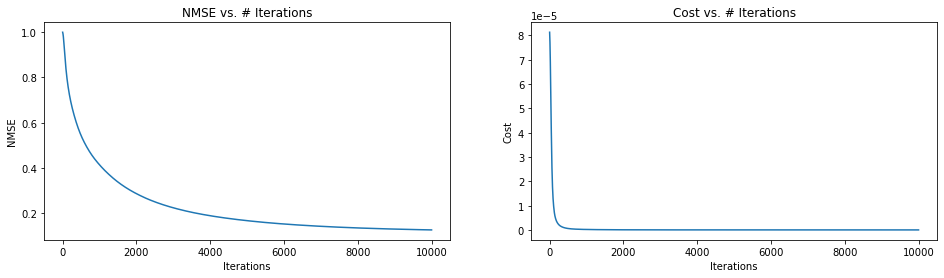


Minimum NMSE = 0.12711194623987665 (at [10000] iterations)
Minimum Cost = 6.96403823551276e-08 (at [10000] iterations)


In [13]:
# Plot NMSE
plot_utils.nmse_cost(nmse_arr, cost, n_iter)